In [1]:
import glob
import os
import json
import mmcv
import numpy as np

In [2]:
path='/data2/rice2/'

In [22]:
annotations=[]
for root, dirs, files in os.walk(path): 
    for f in files: 
        if f[-4:]=='json':
            jsonfile=mmcv.load(os.path.join(root,f))
            for ann in jsonfile['images']:
                imagename=os.path.join(root,ann['image'])
                if os.path.exists(imagename):
                    bboxes=[]
                    for bbox in ann['annotations'][1]['annotations']:
                        tembbox=[int(bbox['annotation']['minX']),int(bbox['annotation']['minY']),int(bbox['annotation']['maxX']),int(bbox['annotation']['maxY'])]
                        if(tembbox[0]<0):tembbox[0]=0
                        if(tembbox[1]<0):tembbox[1]=0
                        if(tembbox[2]>1823):tembbox[2]=1823
                        if(tembbox[3]>1025):tembbox[3]=1025 
                        tembbox=np.asarray(tembbox)
                        tembbox[tembbox<0]=0
                        tembbox=tembbox.tolist()
                        bboxes.append(tembbox)
                    bboxes = np.array(bboxes, ndmin=2)
                    bboxes_ignore = np.zeros((0, 4))
                    labels=np.ones((bboxes.shape[0]))
                    temimage=mmcv.imread(imagename)                
                    oneimg={'filename':imagename[13:],
                        'width': temimage.shape[1],
                        'height': temimage.shape[0],
                        'ann': {
                            'bboxes': bboxes.astype(np.float32),
                            'labels': labels.astype(np.int64),
                            'bboxes_ignore':bboxes_ignore.astype(np.float32)}
                       }
                    if(oneimg['ann']['bboxes'].shape[1]==4):
                        annotations.append(oneimg)

In [17]:
import pandas as pd

In [24]:
annotationspd=pd.DataFrame(annotations)

In [25]:
annotationspd.head()

,ann,filename,height,width
0,"{'bboxes': [[1711.0, 932.0, 1765.0, 982.0], [1...",DJI_0165/0_2053.png,1025,1823
1,"{'bboxes': [[1720.0, 980.0, 1775.0, 1025.0], [...",DJI_0165/1823_0.png,1025,1823
2,"{'bboxes': [[136.0, 347.0, 192.0, 399.0], [167...",DJI_0165/1823_2053.png,1025,1823
3,"{'bboxes': [[1636.0, 88.0, 1693.0, 127.0], [15...",DJI_0165/3646_0.png,1025,1823
4,"{'bboxes': [[166.0, 337.0, 216.0, 398.0], [112...",DJI_0165/3646_2053.png,1025,1823


In [26]:
import tqdm
import albumentations as A

import skimage.io as io
aug=A.Compose([A.RandomCrop(height=768,width=768)],
               bbox_params={'format':'pascal_voc','min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)

In [29]:
annotations=[]
# namenum=1
for i in tqdm.tqdm(range(len(annotationspd))):
    bbox=annotationspd.iloc[i,0]['bboxes']
    labels=annotationspd.iloc[i,0]['labels']
    xxx=io.imread(os.path.join('/data2/rice2/',annotationspd.iloc[i,1]))
    
    for m in range(20):
        augmented=aug(image=xxx,bboxes=bbox, category_id=labels)
        newbb=augmented['bboxes']
        newbb=np.array(newbb, ndmin=2)
        newlabels=np.ones((newbb.shape[0]))
        filename='%02d'%(i)+'-'+ '%02d'%(m)+'.png'
        oneimg={'filename':filename,
                        'width': int(768),
                        'height': int(768),
                        'ann': {
                            'bboxes': newbb.astype(np.float32),
                            'labels': newlabels.astype(np.int64),
                            'bboxes_ignore':bboxes_ignore.astype(np.float32)}
                       }
        if(oneimg['ann']['bboxes'].shape[1]==4):
            annotations.append(oneimg)
            io.imsave(os.path.join('/data2/rice/train',filename),augmented['image'])
#     break

100%|██████████| 125/125 [10:55<00:00,  5.83s/it]


In [30]:
annotationspd=pd.DataFrame(annotations)

In [31]:
len(annotationspd)

2404

In [47]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
#     x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(bbox[0]), int(bbox[2]), int(bbox[1]), int(bbox[3])
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

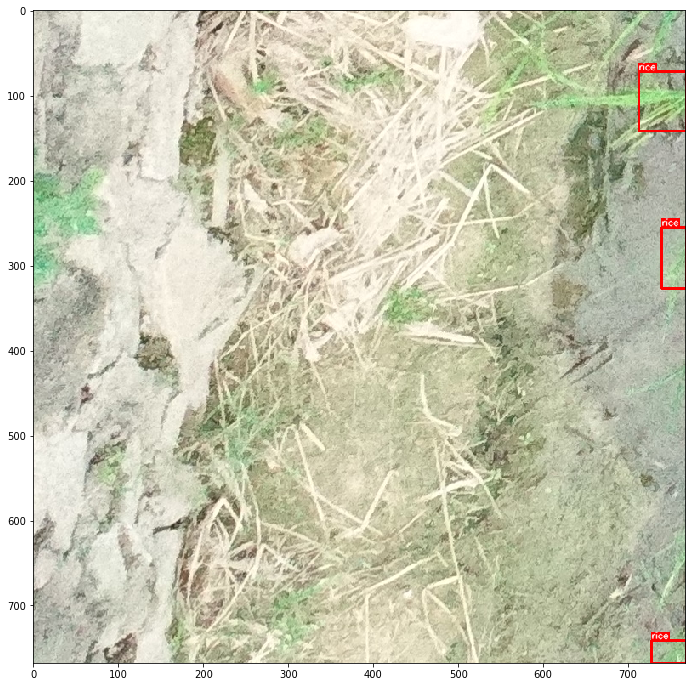

In [77]:
augmented=aug(image=xxx,bboxes=bbox, category_id=labels)
visualize(augmented,{1:'rice'})

In [3]:
mmcv.dump(annotations, '/data2/rice/annotations.pkl')

NameError: name 'annotations' is not defined

In [4]:
temp=mmcv.load('/data2/rice/annotations.pkl')

In [5]:
for dic in temp:
    print(dic.keys())
    break

dict_keys(['filename', 'width', 'height', 'ann'])


In [12]:
for dic in temp:
    dic['ann']['bboxes']=dic['ann']['bboxes'].astype(np.float32)
#     break

In [13]:
mmcv.dump(dic, '/data2/rice/annotations.pkl')

In [131]:
%ls /data2/rice

annotations.pkl  train/


In [2]:
cfg = mmcv.Config.fromfile('configs/cascade_rcnn_r101_fpn_2x-my.py')

In [3]:
cfg.data.train

{'type': 'CustomDataset',
 'ann_file': '/data2/rice/annotations.pkl',
 'img_prefix': '/data2/rice/train/',
 'img_scale': [(384, 768), (768, 768)],
 'img_norm_cfg': {'mean': [123.675, 116.28, 103.53],
  'std': [58.395, 57.12, 57.375],
  'to_rgb': True},
 'size_divisor': 32,
 'flip_ratio': 0,
 'with_mask': False,
 'with_crowd': True,
 'with_label': True}

In [4]:
from mmdet import datasets
from mmcv.runner import obj_from_dict

In [5]:
train_dataset = obj_from_dict(cfg.data.train, datasets)

In [18]:
temp=mmcv.load('/data2/rice/annotations.pkl')

In [24]:
temp[1]['filename']

'01-00.png'

In [56]:
import albumentations as A

from mmdet.datasets.transforms import (ImageTransform, BboxTransform, MaskTransform,
                         Numpy2Tensor)

from mmdet.datasets.utils import to_tensor, random_scale

In [13]:
light=A.Compose([A.RGBShift(),A.InvertImg(),
            A.Blur(),
            A.GaussNoise(),
            A.Flip(),
            A.RandomRotate90()], bbox_params={'format':'pascal_voc','min_visibility': 0.4, 'label_fields': ['category_id']}, p=1)

In [49]:
i=123

In [50]:
xxx=mmcv.imread(os.path.join('/data2/rice/train/',temp[i]['filename']))
bboxs=temp[i]['ann']['bboxes']
gt_labels=temp[i]['ann']['labels']

In [62]:
flip = True
img_scale = (768, 768)  # sample a scale
img_norm_cfg=cfg.data.train.img_norm_cfg

In [65]:
img_transform = ImageTransform(size_divisor=32, **img_norm_cfg)

In [67]:
img, img_shape, pad_shape, scale_factor = img_transform(
            xxx, img_scale, flip)

In [75]:
bbox_transform=BboxTransform()
gt_bboxes = bbox_transform(bboxs, img_shape, scale_factor,flip)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


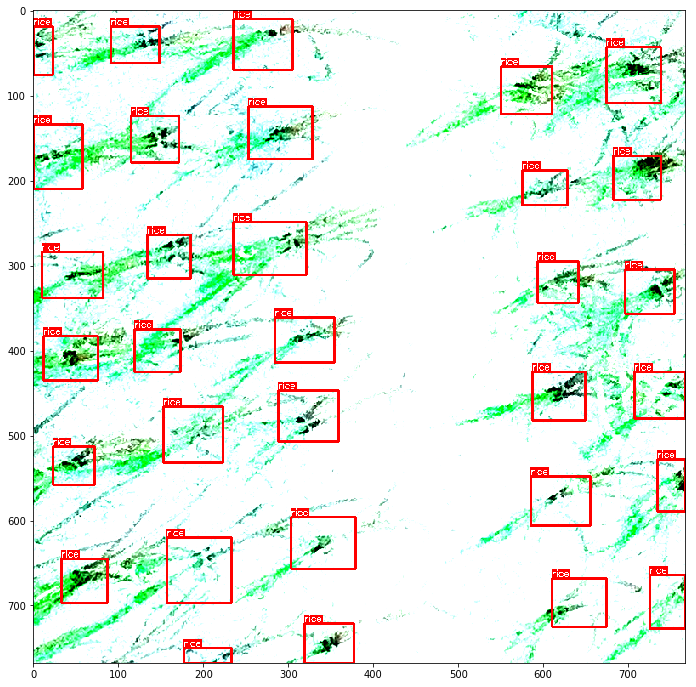

In [76]:
annotations = {'image':img.transpose(1,2,0), 'bboxes': gt_bboxes, 'category_id': aumed['category_id']}
category_id_to_name = {1: 'rice'}
visualize(annotations, category_id_to_name)

In [ ]:
gt_bboxes = BboxTransform(bboxs, img_shape, scale_factor,
                                        flip)

In [51]:
aumed=light(image=xxx,bboxes=bboxs, category_id=gt_labels)

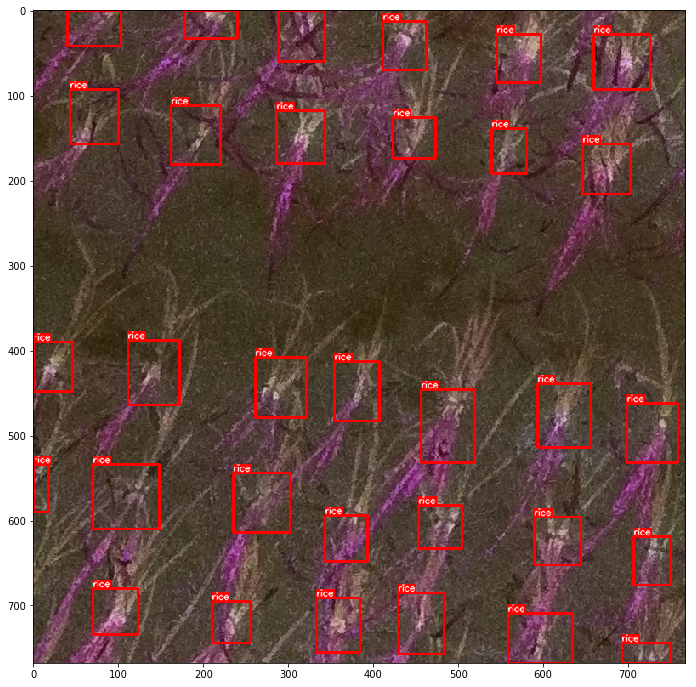

In [52]:
annotations = {'image': aumed['image'], 'bboxes': aumed['bboxes'], 'category_id': aumed['category_id']}
category_id_to_name = {1: 'rice'}
visualize(annotations, category_id_to_name)

# 预测

In [31]:
from mmcv.runner import load_checkpoint
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result
from mmdet.datasets import to_tensor
from mmdet.datasets.transforms import ImageTransform
from mmdet.core import get_classes
cfg = mmcv.Config.fromfile('configs/cascade_rcnn_r101_fpn_2x-my.py')
cfg.model.pretrained = None

# construct the model and load checkpoint
model = build_detector(cfg.model, test_cfg=cfg.test_cfg)
_ = load_checkpoint(model, '/data2/rice/log2/latest.pth')

In [32]:
score_thr=0.8
bbox_color='green'
text_color='green'
thickness=1
font_scale=0.5
show=True
win_name=''
wait_time=0
out_file=None
class_names=['rice']

In [35]:
img = mmcv.imread('/data2/rice2/DJI_0177/3646_2053.png')
result = inference_detector(model, img, cfg)

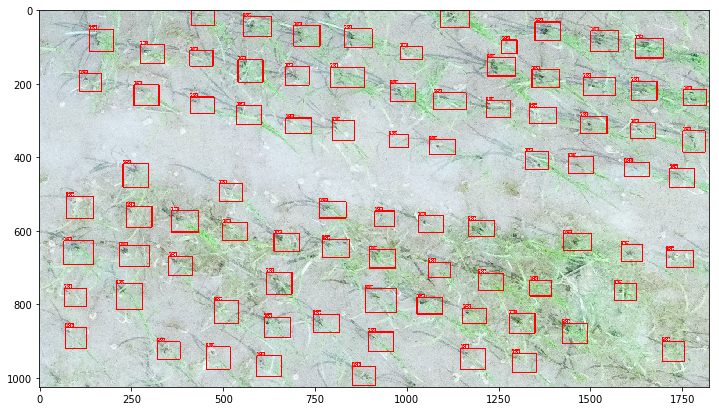

In [36]:
bboxes = np.vstack(result)
newboxes=[]
for i in range(bboxes.shape[0]):
    if(bboxes[i,-1]>score_thr):
        newboxes.append(bboxes[i,:4].astype(np.int32))
newboxes=np.asarray(newboxes)
ids=np.ones((newboxes.shape[0]),dtype='uint8')
annotations = {'image': img, 'bboxes': newboxes, 'category_id': ids}
category_id_to_name = {1: 'rice'}
visualize(annotations, category_id_to_name)

In [44]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
#     x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(bbox[0]), int(bbox[2]), int(bbox[1]), int(bbox[3])
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [19]:
annotations=pd.DataFrame(temp)

In [20]:
annotations.head()

,ann,filename,height,width
0,"{'bboxes': [[696.0, 744.0, 750.0, 768.0], [661...",00-10.png,768,768
1,"{'bboxes': [[746.0, 56.0, 768.0, 112.0], [729....",01-00.png,768,768
2,"{'bboxes': [[360.0, 449.0, 424.0, 507.0], [360...",01-01.png,768,768
3,"{'bboxes': [[672.0, 73.0, 726.0, 129.0], [655....",01-02.png,768,768
4,"{'bboxes': [[618.0, 48.0, 688.0, 122.0], [312....",01-03.png,768,768


In [26]:
img=mmcv.imread('/data2/rice/train/'+annotations.iloc[1,1])
newboxes=annotations.iloc[1,0]['bboxes']
ids=np.ones((newboxes.shape[0]))

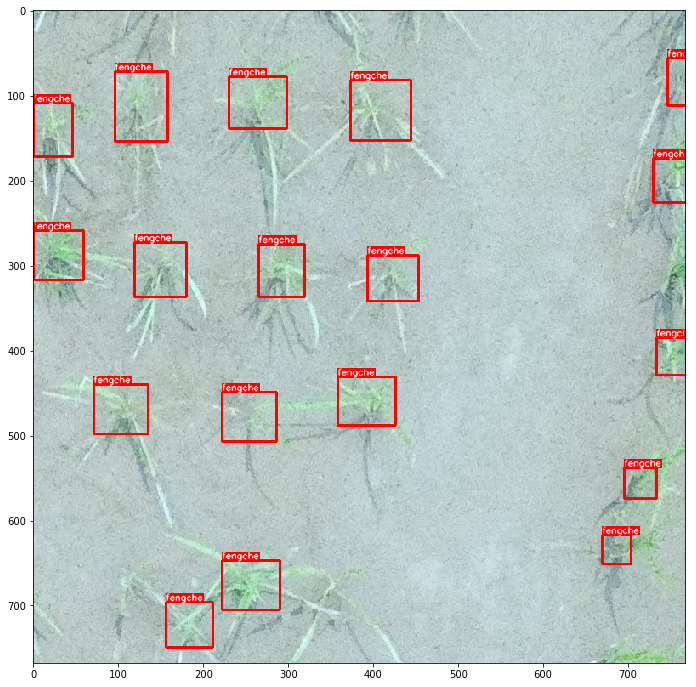

In [28]:
show = {'image': img, 'bboxes': newboxes, 'category_id': ids}
category_id_to_name = {1: 'fengche'}
visualize(show, category_id_to_name)